# Modelling

In [126]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import statistics
from visualisations import compare_histograms
import random
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import modelling as ml
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
import pickle
import shap
import gzip, pickle, pickletools

# set random seed for reproducibility
np.random.seed(42)

sns.set_theme(context='notebook', style='darkgrid', palette='Set3')

In [127]:
# Import label encoded and ready for modelling set from 02 file 
df = pd.read_csv('../data/modelling_wines.csv')
df.set_index('name', inplace=True)
df.head()

,region,country,vintage,producer,wine_variety,grape_variety,price,rating,rating_qty,abv,from_vivino,log_price,age
name,,,,,,,,,,,,,
00 Wines Vgw Chardonnay 2017,303.0,20.0,36.0,0.0,3.0,23.0,65.71,0.0,0.0,13.000000,0.0,4.185251,7.0
00 Wines Vgr Pinot Noir 2019,303.0,20.0,38.0,0.0,0.0,95.0,82.14,0.0,0.0,12.900000,0.0,4.408425,5.0
00 Wines Egw Chardonnay 2019,303.0,20.0,38.0,0.0,3.0,23.0,95.28,0.0,0.0,13.504946,0.0,4.556820,5.0
100 Nails Ranch Pinot Noir 2019,61.0,20.0,38.0,1.0,0.0,95.0,13.96,0.0,0.0,14.200000,0.0,2.636196,5.0
100 Nails Ranch Chardonnay 2019,248.0,20.0,38.0,1.0,3.0,23.0,13.96,0.0,0.0,14.200000,0.0,2.636196,5.0


In [128]:
df_30plusratings = df[df['rating_qty'] > 30]
X = df_30plusratings.drop(columns = ['log_price', 'price'])
y = df_30plusratings['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.85)

# Baseline Model

Basic Linear Regression with nulls imputed from median 

In [129]:
# df_encoded['abv'].fillna(df_encoded['abv'].median(), inplace=True)

In [130]:
# lr = LinearRegression()

# lr.fit(X_train, y_train)
# y_pred = lr.predict(X_test)
# print(f" Cross validated r2: {cross_val_score(lr, X_train, y_train, cv = 10,scoring='r2')}")
# print(f" Mean squared error: {np.sqrt(mean_squared_error(y_test, y_pred))}")

In [131]:
# df_encoded = pd.get_dummies(df, columns=['country', 'vintage', 'wine_variety', 
#                                         'grape_variety', 'from_vivino'],  drop_first=True, dtype=int)
# # df_encoded['abv'].fillna(df_encoded['abv'].median(), inplace=True)

# X = df.drop(columns = ['log_price', 'price'])
# y = df['log_price']

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.85)

In [132]:
# lr = LinearRegression()

# lr.fit(X_train, y_train)
# y_pred = lr.predict(X_test)
# print(f" Cross validated r2: {cross_val_score(lr, X_train, y_train, cv = 10,scoring='r2')}")
# print(f" Root mean squared error: {np.sqrt(mean_squared_error(y_test, y_pred))}")

In [133]:
# results = ml.regression_model_selector(X_train, y_train, X_test, y_test)
# results

In [134]:
# results['date/desc'] = '7/3 | ABV imputed LR | Target: PRICE | Features: all features label encoded'
# model_tracker_current = pd.read_csv('../data/model_tracker.csv')
# model_tracker_current = pd.concat([model_tracker_current, results])
# model_tracker_current.to_csv('../data/model_tracker.csv', index=False)
# model_tracker_current


## Decision Tree Regression

In [135]:
# No hyper parameter tuning
dt = DecisionTreeRegressor(random_state=42)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print(f"Root Mean Squared Error (RMSE): {np.exp(np.sqrt(mean_squared_error(y_test, y_pred)))}")
print(f"R-squared (R2): {r2_score(y_test, y_pred)}")

Root Mean Squared Error (RMSE): 1.1814619174814387
R-squared (R2): 0.9682522509755589


In [136]:
dt = DecisionTreeRegressor(random_state=42, )
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2]
}

gs = GridSearchCV(estimator=dt, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', 
                           verbose=2, n_jobs=-1)

gs.fit(X_train, y_train)

print("Best parameters found: ", gs.best_params_)

print("Best score:", gs.best_score_)

best_model = gs.best_estimator_

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test Price RMSE: {np.exp(np.sqrt(mean_squared_error(y_test, y_pred)))}")

# Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3}
# Best score: -0.06097922282343639
# Test Price RMSE: 1.1965245503424489

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=3; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=3; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=3; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=3; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=3; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5;

In [137]:
# Best parameters found:  {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10}
# After hyper parameter tuning
dt_tuned = DecisionTreeRegressor(max_depth = None, min_samples_leaf = 1, min_samples_split = 3, random_state=42)

dt_tuned.fit(X_train, y_train)

y_pred = dt_tuned.predict(X_test)

print(f"Root Mean Squared Error (RMSE): {round(np.exp(np.sqrt(mean_squared_error(y_test, y_pred))),3)}")
print(f"R-squared (R2): {round(r2_score(y_test, y_pred),3)}")

print(f"Cross validated r2: {round(cross_val_score(dt_tuned, X_train, y_train, cv = 10).mean(), 3)}")

Root Mean Squared Error (RMSE): 1.181
R-squared (R2): 0.968
Cross validated r2: 0.952


Root Mean Squared Error (RMSE): 1.197<br>
R-squared (R2): 0.962<br>
Cross validated r2: 0.943<br>

In [138]:
importances = dt_tuned.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(11):
    print(f"{f + 1}. feature {X.columns[indices[f]]} ({importances[indices[f]]:.3f})")


Feature ranking:
1. feature rating (0.606)
2. feature vintage (0.081)
3. feature country (0.060)
4. feature rating_qty (0.055)
5. feature region (0.052)
6. feature producer (0.051)
7. feature age (0.043)
8. feature grape_variety (0.024)
9. feature abv (0.018)
10. feature from_vivino (0.007)
11. feature wine_variety (0.004)


# PCA including Regions & Producers

In [139]:
# df_encoded_pca = pd.get_dummies(df, columns=['country', 'vintage', 'wine_variety', 
#                                         'grape_variety', 'from_vivino', 'producer', 'region'],  drop_first=True, dtype=int)
# df_encoded_pca['abv'].fillna(df_encoded['abv'].median(), inplace=True)

# X = df_encoded_pca.drop(columns = ['log_price', 'reviewed_by'])
# y = df['log_price']

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.85)

# for i in [200, 500, 1000, 2000]:
#     pca = PCA(n_components=i)

#     pca.fit(X_train)

#     Z_train = pca.transform(X_train)
#     Z_test = pca.transform(X_test)
#     lr.fit(Z_train, y_train)
#     print(f'N-Components: {i}')
#     print(f'Training Score: {round(lr.score(Z_train, y_train),4)}')
#     print(f'Testing Score: {round(lr.score(Z_test, y_test),4)}')

#     y_pred = lr.predict(Z_test)

#     print(f" Cross validated r2: {cross_val_score(lr, Z_train, y_train, cv = 5)}")
#     print(f" Root mean squared error: {np.sqrt(mean_squared_error(y_test, y_pred))}")

In [140]:
# pca = PCA(n_components=2500)

# pca.fit(X_train)

# Z_train = pca.transform(X_train)
# Z_test = pca.transform(X_test)

# best_dt_pca = best_model.fit(Z_train, y_train)

# y_pred_pca = best_dt_pca.predict(Z_test)
# mse_pca = mean_squared_error(y_test, y_pred_pca)
# print(f"Test RMSE: {np.sqrt(mse_pca)}")

## Random Forests Regression 

In [141]:
# np.random.seed(42)
# rf = RandomForestRegressor()
# param_grid = {
#     'max_depth': [None, 10, 20, 40],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# gs = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            cv=5, scoring='neg_mean_squared_error', 
#                            verbose=2, n_jobs=-1)

# gs.fit(X_train, y_train)

# print("Best parameters found: ", gs.best_params_)

# print("Best score:", gs.best_score_)

# rf_best_model = gs.best_estimator_

# y_pred = best_model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print(f"Test RMSE: {np.exp(np.sqrt(mse))}")

# print(f"R-squared (R2): {round(r2_score(y_test, y_pred),3)}")

# print(f"Cross validated r2: {round(cross_val_score(rf_best_model, X_train, y_train, cv = 10).mean(), 3)}")


In [142]:
#Best parameters found:  {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2}

rf_tuned = RandomForestRegressor(max_depth = 40, min_samples_leaf = 1, min_samples_split = 2, random_state=42)
rf_tuned = rf_tuned.fit(X_train, y_train)
y_pred = rf_tuned.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test RMSE price: {np.exp(np.sqrt(mse))}")
print(f'Training Score: {round(rf_tuned.score(X_train, y_train),4)}')
print(f'Testing Score: {round(rf_tuned.score(X_test, y_test),4)}')
# Test RMSE price: 1.1915478395375665
# Training Score: 0.995
# Testing Score: 0.9637

Test RMSE price: 1.1525723750252364
Training Score: 0.9961
Testing Score: 0.977


In [143]:
# X = df.drop(columns = ['log_price', 'price'])
# y = df['log_price']

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.85)

# rf_tuned = RandomForestRegressor(max_depth = 40, min_samples_leaf = 1, min_samples_split = 2)
# rf_tuned = rf_tuned.fit(X_train, y_train)
# y_pred = rf_tuned.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print(f"Test RMSE price: {np.exp(np.sqrt(mse))}")
# print(f'Training Score: {round(rf_tuned.score(X_train, y_train),4)}')
# print(f'Testing Score: {round(rf_tuned.score(X_test, y_test),4)}')

# # RESULTS 
# # Test RMSE price: 1.360004955078327
# # Training Score: 0.9869
# # Testing Score: 0.9051

In [144]:
# # Remove wines with less then 30 ratings based on EDA finding that correlation between price and rating was much higher with
# # more reliable ratings. 
# np.random.seed(42)

# rf_tuned = RandomForestRegressor(max_depth = 40, min_samples_leaf = 1, min_samples_split = 2, random_state=42)
# rf_tuned = rf_tuned.fit(X_train, y_train)
# y_pred = rf_tuned.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print(f"Test RMSE price: {np.exp(np.sqrt(mse))}")
# print(f'Training Score: {round(rf_tuned.score(X_train, y_train),4)}')
# print(f'Testing Score: {round(rf_tuned.score(X_test, y_test),4)}')

# # Test RMSE price: 1.171555724949263
# # Training Score: 0.9958
# # Testing Score: 0.9704

**Model Performance:**<br>
Test RMSE price: 1.1636248759919523<br>
Training Score: 0.9967<br>
Testing Score: 0.9754<br>

Model clearly much more reliable when 

# Feature Importance of Decision Tree Model

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


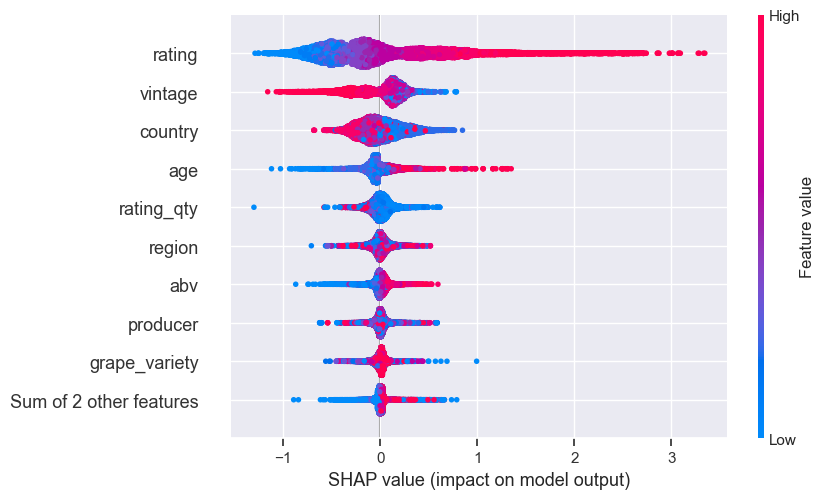

In [145]:
# taking hours to run for some reason 
explainer = shap.Explainer(dt_tuned)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values);

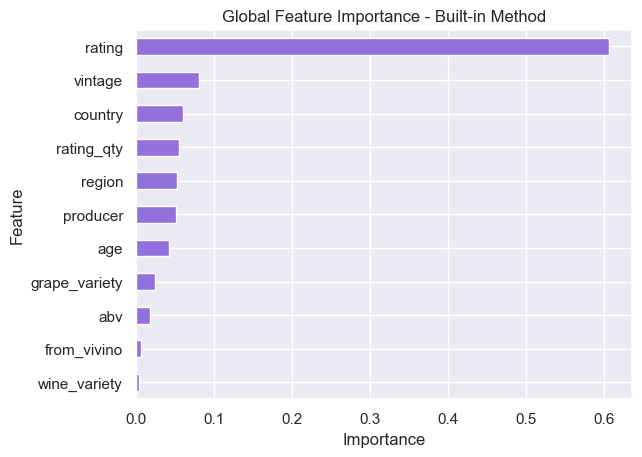

In [146]:
# code from https://forecastegy.com/posts/feature-importance-in-random-forests/#:~:text=Permutation%20feature%20importance%20is%20another,out%2Dof%2Dsample%20dataset.

global_importances = pd.Series(dt_tuned.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='mediumpurple')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method");

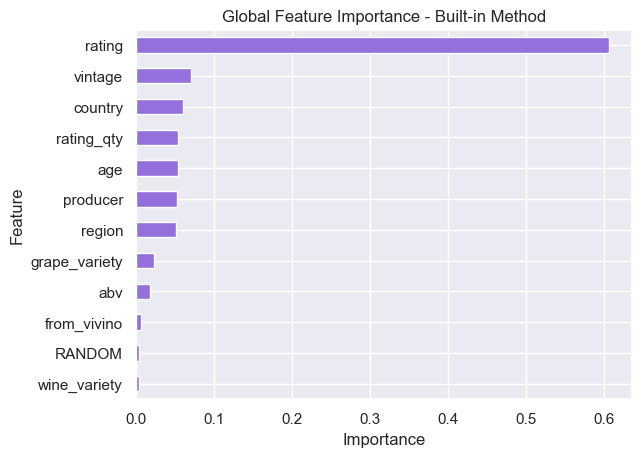

In [147]:
X_train_random = X_train.copy()
X_train_random["RANDOM"] = np.random.RandomState(42).randn(X_train.shape[0])

dtree_random_feat_imp = DecisionTreeRegressor(max_depth = None, min_samples_leaf = 1, min_samples_split = 3, random_state=42)
dtree_random_feat_imp.fit(X_train_random, y_train)

global_importances_random = pd.Series(dtree_random_feat_imp.feature_importances_, index=X_train_random.columns)
global_importances_random.sort_values(ascending=True, inplace=True)
global_importances_random.plot.barh(color='mediumpurple')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method");

* Best performing model on test data includes all wines, targets log_price and is a random forests classifier with the following parameters: max_depth = 40, min_samples_leaf = 1, min_samples_split = 2. 

## Recursive Feature Elimination

Recursive Feature Elimination (RFE) - to see which features are most important to the RF model. These might eventually be the features users (or an API) inputs into the app. 

In [148]:
# model = RandomForestRegressor(random_state=42)

# # Initialize RFE with the linear regression model and desired number of features
# rfe_lr = RFE(estimator=model, n_features_to_select=5, step=1)
# rfe_lr.fit(X, y)
# print("Feature ranking (1 indicates selected):", rfe_lr.ranking_)

# # Print the mask of selected features
# print("Mask of selected features:", rfe_lr.support_)

# # Mapping back to feature names
# selected_features = X.columns[rfe_lr.support_]
# print("Selected features:", selected_features)

**Random Forests Features Ranking (5 features to select)**<br>
Feature ranking (1 indicates selected): [1 4 1 1 7 5 1 1 3 6 2]<br>
Mask of selected features: [ True False  True  True False False  True  True False False False]<br>
Selected features: Index(['region', 'vintage', 'producer', 'rating', 'rating_qty'], dtype='object')<br>

**Decision Trees Features Ranking (1 feature to select)**<br>
Feature ranking (1 indicates selected): [ 7  6  8  5 10  9  2  3  1 11  4]<br>
Mask of selected features: [False False False False False False False False  True False False]<br>
Selected features: Index(['abv'], dtype='object')<br>

In [149]:
# %%time 
# rf_final.predict(X_test)

# Exporting files for the App

In [150]:
filepath = '../models/casi_dt_v1.pkl'
with gzip.open(filepath, "wb") as f:
    pickled = pickle.dumps(dt_tuned)
    optimized_pickle = pickletools.optimize(pickled)
    f.write(optimized_pickle)

In [151]:
app_frontend = pd.read_csv('../data/clean_combined_wines.csv', index_col=0)
def to_normal_case(column_name):
    return ' '.join(word.capitalize() for word in column_name.split('_'))
app_frontend.columns = [to_normal_case(column) for column in app_frontend.columns]
app_frontend.rename(columns = {'Abv': 'ABV', 'Rating': 'Average Rating', 'Price' : 'Price (£)'}, inplace=True)
app_frontend.drop(columns = ['Reviewed By', 'From Vivino', 'Rating Qty'], inplace=True)
app_frontend['Wine Variety'] = app_frontend['Wine Variety'].apply(to_normal_case)

app_frontend.head()

,Region,Country,Vintage,Producer,Wine Variety,Grape Variety,Price (£),Average Rating,ABV,Log Price,Age
name,,,,,,,,,,,
00 Wines Vgw Chardonnay 2017,Willamette Valley,United States,2017,00 Wines,White,Chardonnay,65.71,0.0,13.0,4.185251,7
00 Wines Vgr Pinot Noir 2019,Willamette Valley,United States,2019,00 Wines,Red,Pinot Noir,82.14,0.0,12.9,4.408425,5
00 Wines Egw Chardonnay 2019,Willamette Valley,United States,2019,00 Wines,White,Chardonnay,95.28,0.0,NaN,4.556820,5
100 Nails Ranch Pinot Noir 2019,Central Coast,United States,2019,100 Nails Ranch,Red,Pinot Noir,13.96,0.0,14.2,2.636196,5
100 Nails Ranch Chardonnay 2019,Sonoma County,United States,2019,100 Nails Ranch,White,Chardonnay,13.96,0.0,14.2,2.636196,5


In [152]:
# concatenate join X_test and y_test
test_backend = pd.concat([X_test, y_test], axis=1)

# make the index of test_dataframe into a column called 'name'
app_frontend = app_frontend[~app_frontend.index.duplicated(keep='first')]
test_backend = test_backend[~test_backend.index.duplicated(keep='first')]

# Reindexing app_frontend to match the index of test_backend
app_frontend_aligned = app_frontend.reindex(test_backend.index)

# sort both by index
app_frontend_aligned = app_frontend_aligned.sort_index()
test_backend = test_backend.sort_index()

app_frontend_aligned.reset_index(inplace=True)
# test_backend.reset_index(inplace=True)
# app_frontend_aligned.rename(columns = {'name': 'Name'}, inplace=True)

test_backend.to_csv('../data/app_backend.csv', index=False)
app_frontend_aligned.to_csv('../data/app_frontend.csv', index=False)

print(test_backend.shape)
print(app_frontend_aligned.shape)

(4308, 12)
(4308, 12)


In [153]:
app_frontend_aligned

,name,Region,Country,Vintage,Producer,Wine Variety,Grape Variety,Price (£),Average Rating,ABV,Log Price,Age
0,14 Hands Cabernet Sauvignon 2015,Columbia Valley,United States,2015,14 Hands,Red,Cabernet Sauvignon,9.71,3.6,NaN,2.273156,9
1,14 Hands Merlot 2016,Columbia Valley,United States,2016,14 Hands,Red,Merlot,11.30,3.8,NaN,2.424803,8
2,19 Crimes Red Blend 2018,Victoria,Australia,2018,19 Crimes,Red,Red Blend,7.94,3.9,NaN,2.071913,6
3,19 Crimes Red Blend 2020,unknown,Australia,2020,19 Crimes,Red,Other Red Blends,8.21,3.9,NaN,2.105353,4
4,19 Crimes Snoop Cali Rose 2020,California,United States,2020,19 Crimes,Rose,Rose,11.49,3.9,10.5,2.441477,4
...,...,...,...,...,...,...,...,...,...,...,...,...
4303,Zonin Valpolicella Ripasso Superiore 2017,Valpolicella Ripasso,Italy,2017,Zonin,Red,Unknown,7.06,3.7,NaN,1.954445,7
4304,Zonin Veneto Velluto Appassimento 2017,Veneto,Italy,2017,Zonin,Red,Unknown,5.84,3.7,NaN,1.764731,7
4305,Zonnebloem Cabernet Sauvignon 2018,Stellenbosch,South Africa,2018,Zonnebloem,Red,Cabernet Sauvignon,6.94,3.6,NaN,1.937302,6
4306,Zonnebloem Merlot 2017,Stellenbosch,South Africa,2017,Zonnebloem,Red,Merlot,6.94,3.8,NaN,1.937302,7


In [154]:
test_backend

,region,country,vintage,producer,wine_variety,grape_variety,rating,rating_qty,abv,from_vivino,age,log_price
name,,,,,,,,,,,,
14 Hands Cabernet Sauvignon 2015,80.0,20.0,34.0,6.0,2.0,18.0,3.6,2598.0,13.887549,1.0,9.0,2.273156
14 Hands Merlot 2016,80.0,20.0,35.0,6.0,1.0,68.0,3.8,876.0,13.858855,1.0,8.0,2.424803
19 Crimes Red Blend 2018,289.0,1.0,37.0,8.0,0.0,101.0,3.9,7785.0,14.315798,1.0,6.0,2.071913
19 Crimes Red Blend 2020,305.0,1.0,39.0,8.0,0.0,83.0,3.9,50.0,13.346729,0.0,4.0,2.105353
19 Crimes Snoop Cali Rose 2020,47.0,20.0,39.0,8.0,1.0,117.0,3.9,32.0,10.500000,0.0,4.0,2.441477
...,...,...,...,...,...,...,...,...,...,...,...,...
Zonin Valpolicella Ripasso Superiore 2017,282.0,10.0,36.0,6680.0,2.0,146.0,3.7,1610.0,12.880891,1.0,7.0,1.954445
Zonin Veneto Velluto Appassimento 2017,285.0,10.0,36.0,6680.0,3.0,146.0,3.7,285.0,12.321473,1.0,7.0,1.764731
Zonnebloem Cabernet Sauvignon 2018,258.0,17.0,37.0,6681.0,3.0,18.0,3.6,84.0,12.987193,1.0,6.0,1.937302


In [155]:
# SAND BOX RUN FROM HERE 

df_backend = pd.read_csv('../data/app_backend.csv')
df_frontend = pd.read_csv('../data/app_frontend.csv')

# Select a random row
random_index = random.randint(0, len(df_backend) - 1)
random_row_b = df_backend.loc[random_index]
random_row_f = df_frontend.loc[random_index]

In [156]:
random_row_b.to_frame().transpose()

,region,country,vintage,producer,wine_variety,grape_variety,rating,rating_qty,abv,from_vivino,age,log_price
1075,201.0,5.0,28.0,1538.0,0.0,97.0,4.3,255.0,13.954143,1.0,15.0,4.177459


In [157]:
random_row_b.values.reshape(1, -1)

array([[2.01000000e+02, 5.00000000e+00, 2.80000000e+01, 1.53800000e+03,
        0.00000000e+00, 9.70000000e+01, 4.30000000e+00, 2.55000000e+02,
        1.39541429e+01, 1.00000000e+00, 1.50000000e+01, 4.17745947e+00]])